In [1]:
from socceraction.data.wyscout import PublicWyscoutLoader
from socceraction.spadl.wyscout import convert_to_actions as convert_to_actions_wyscout
from socceraction.spadl.statsbomb import convert_to_actions as convert_to_actions_statsbomb
from socceraction.data.opta import OptaLoader
from socceraction.data.statsbomb import StatsBombLoader
from socceraction.spadl.config import actiontypes, bodyparts
import socceraction.spadl as spadl
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, roc_auc_score, brier_score_loss, log_loss, mean_absolute_error, r2_score, mean_absolute_percentage_error
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, matthews_corrcoef, balanced_accuracy_score
from xgboost import XGBClassifier, XGBRegressor
from catboost import CatBoostClassifier
import math
import pickle
import os
from name_matching.name_matcher import NameMatcher
from rapidfuzz import fuzz
from imblearn.over_sampling import RandomOverSampler, SMOTE
from imblearn.under_sampling import RandomUnderSampler
from sklearn.feature_selection import r_regression, SelectKBest, chi2, mutual_info_classif, SequentialFeatureSelector, RFECV, SelectFromModel
from scipy.stats import pearsonr, chisquare
from mrmr import mrmr_classif
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.svm import LinearSVR, SVC
from sklearn.linear_model import Lasso, LogisticRegression

In [2]:
# IMPORTANT CONSTANTS AND MAPS
MAPS_PLAYER_SKILL_PROBABILITIES_GENERATOR = {
    "xpass" : {
        "model_directory" : "data/model_xpass/",
        "csv_output_filename" : "xpass_player_skill_probs_dataset.csv",
        "type_ids_spadl" : [0,1]
    },
    "xgoal" : {
        "model_directory" : "data/model_xgoal/",
        "csv_output_filename" : "xgoal_player_skill_probs_dataset.csv",
        "type_ids_spadl" : [11, 12, 13]
    },
    "xdribble" : {
        "model_directory" : "data/model_xdribble/",
        "csv_output_filename" : "xdribble_player_skill_probs_dataset.csv",
        "type_ids_spadl" : [7, 21]
    }
}
DIRECTORY_STATSBOMB_NON_360_CSV_DATAS = "data/statsbomb_event_non_360_data"
DIRECTORY_FINAL_PLAYERS_CSV_DATAS = "data/players_skill_dataset/final_players_skill_dataset.csv"

In [3]:
api_statsbomb = StatsBombLoader(root="data/statsbomb", getter="local")

In [4]:
def convert_events_df_to_spadl_statsbomb(events_df, home_team_id):
    spadl_events_df = convert_to_actions_statsbomb(events_df, home_team_id)
    spadl_events_df['time_seconds'] = spadl_events_df['time_seconds'].astype('float64')
    spadl_events_df['timestamp'] = pd.to_datetime(spadl_events_df['time_seconds'], unit='s')
    return spadl_events_df

In [5]:
def collect_all_raw_statsbomb_non_360_spadl():
    api = api_statsbomb
    list_competitions_ids = []
    list_game_ids = []

    competitions_df = api.competitions()
    for _, row in competitions_df.iterrows():
        if row['competition_gender'] == 'male':
                list_competitions_ids.append((row['competition_id'], row['season_id']))
        
    for competition_id, season_id in list_competitions_ids:
        games_df = api.games(competition_id, season_id)
        for _, row in games_df.iterrows():
            list_game_ids.append((row['game_id'], row['home_team_id'], row['away_team_id']))
            
    for game_id, home_team_id, away_team_id in list_game_ids:
        this_game_events_df = api.events(game_id)
        this_game_events_spadl_df = convert_events_df_to_spadl_statsbomb(this_game_events_df, home_team_id)
        # Export to external csv iteratively
        this_game_events_spadl_df.to_csv(f'data/statsbomb_event_non_360_data/{game_id}_{home_team_id}_{away_team_id}_statsbomb_event_non_360_data.csv')         

In [6]:
# Comment it if statsbomb event 360 data already collected
# collect_all_raw_statsbomb_non_360_spadl()

In [7]:
def load_and_concat_statsbomb_non_360_df_from_csv():
    list_pass_event_df = []
    for filename in os.listdir(DIRECTORY_STATSBOMB_NON_360_CSV_DATAS):
        f = os.path.join(DIRECTORY_STATSBOMB_NON_360_CSV_DATAS, filename)
        if os.path.isfile(f):
            pass_event_df = pd.read_csv(f)
            list_pass_event_df.append(pass_event_df)
    return pd.concat(list_pass_event_df)

In [8]:
big_statsbomb_non_360_events_df = load_and_concat_statsbomb_non_360_df_from_csv()
big_statsbomb_non_360_events_df.head()

,Unnamed: 0,game_id,original_event_id,period_id,time_seconds,team_id,player_id,start_x,start_y,end_x,end_y,type_id,result_id,bodypart_id,action_id,timestamp
0,0,15946,549567bd-36de-4ac8-b8dc-6b5d3f1e4be8,1,0.0,206,6581.0,52.058824,33.655696,76.058824,23.240506,0,1,4,0,1970-01-01 00:00:00.000
1,1,15946,44679971-4477-441a-947b-eca1d7786aaf,1,2.0,206,6855.0,76.058824,23.240506,73.411765,22.637975,21,1,0,1,1970-01-01 00:00:02.000
2,2,15946,4e4e4cad-9897-43ec-842d-585a4077f6ce,1,3.0,206,6855.0,73.411765,22.637975,29.558824,63.007595,0,0,5,2,1970-01-01 00:00:03.000
3,3,15946,be27cc25-92b5-4696-b43c-aad957a6119a,1,7.0,217,5203.0,28.764706,63.782278,30.088235,53.108861,0,1,0,3,1970-01-01 00:00:07.000
4,4,15946,b33c0b7f-7456-4efe-b43c-5fd7cbd14689,1,8.0,217,5470.0,30.088235,53.108861,31.058824,64.298734,0,1,1,4,1970-01-01 00:00:08.000


In [9]:
final_player_skills_dataset = pd.read_csv(DIRECTORY_FINAL_PLAYERS_CSV_DATAS)
final_player_skills_dataset.dropna(subset="player_id", inplace=True)
final_player_skills_dataset.head()

,Unnamed: 0.2,Unnamed: 0.1,level_0,dex,index,Unnamed: 0,game_id,team_id,player_id,player_name,...,LWB,LDM,CDM,RDM,RWB,LB,LCB,CB,RCB,RB
0,0,85996.0,0.0,0.0,16.0,16.0,9827.0,208.0,6921.0,Matías Aguirregaray Guruceaga,...,71+2,70+2,70+2,70+2,71+2,71+2,70+2,70+2,70+2,71+2
1,1,85926.0,0.0,0.0,18.0,18.0,9742.0,221.0,6683.0,Cheick Doukouré,...,64+2,65+2,65+2,65+2,64+2,64+2,63+2,63+2,63+2,64+2
2,2,85915.0,0.0,0.0,22.0,22.0,9661.0,215.0,6395.0,Kepa Arrizabalaga Revuelta,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,3,85914.0,0.0,0.0,27.0,27.0,9650.0,223.0,6848.0,Andrés Tomás Prieto Albert,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,4,85876.0,0.0,0.0,27.0,27.0,9642.0,212.0,19669.0,Osvaldo Nicolás Fabián Gaitán,...,64+3,61+3,61+3,61+3,64+3,60+3,51+3,51+3,51+3,60+3


In [10]:
def count_total_success_action(row, statsbomb_event_non_360_df, list_type_ids, count_total):
    event_data_for_this_player_and_type = statsbomb_event_non_360_df[ \
        (statsbomb_event_non_360_df['player_id'] == row['player_id']) & \
        (statsbomb_event_non_360_df['type_id'].isin(list_type_ids))
    ]
    value_counts_success_df = event_data_for_this_player_and_type['result_id'].value_counts()
    total_success_action = 0
    total_action = 0
    for value, counter in value_counts_success_df.items():
        if (value == 1):
            total_success_action += counter
        total_action += counter
    return total_success_action if not count_total else total_action

def construct_player_skills_probabilities_dataset(statsbomb_event_non_360_df, final_player_skill_df):
    for key in list(MAPS_PLAYER_SKILL_PROBABILITIES_GENERATOR.keys()):
        list_type_ids = MAPS_PLAYER_SKILL_PROBABILITIES_GENERATOR[key]["type_ids_spadl"]
        directory_model = MAPS_PLAYER_SKILL_PROBABILITIES_GENERATOR[key]["model_directory"]
        output_csv_filename = MAPS_PLAYER_SKILL_PROBABILITIES_GENERATOR[key]["csv_output_filename"]

        modified_final_player_skills_df = final_player_skill_df.copy()
        modified_final_player_skills_df['statistic_total_success_action'] = modified_final_player_skills_df.apply(lambda x : count_total_success_action(x, statsbomb_event_non_360_df, list_type_ids, False), axis=1)
        modified_final_player_skills_df['statistic_total_action'] = modified_final_player_skills_df.apply(lambda x : count_total_success_action(x, statsbomb_event_non_360_df, list_type_ids, True), axis=1)
        modified_final_player_skills_df['statistic_success_action_probs'] = modified_final_player_skills_df['statistic_total_success_action'] / modified_final_player_skills_df['statistic_total_action']

        modified_final_player_skills_df = modified_final_player_skills_df[modified_final_player_skills_df['statistic_total_action'] != 0]
        modified_final_player_skills_df.to_csv(directory_model + output_csv_filename)

In [11]:
# Comment it out if player skill probabilities dataset already constructed
# construct_player_skills_probabilities_dataset(big_statsbomb_non_360_events_df, final_player_skills_dataset)

In [12]:
# Add additional computed field into xpass df (Comment it if already computed !!)
# directory_model = MAPS_PLAYER_SKILL_PROBABILITIES_GENERATOR["xpass"]["model_directory"]
# output_csv_filename = MAPS_PLAYER_SKILL_PROBABILITIES_GENERATOR["xpass"]["csv_output_filename"]
# xpass_player_probs_df = pd.read_csv(directory_model + output_csv_filename)
# total_success_passes_all_players = xpass_player_probs_df['statistic_total_success_action'].sum()
# xpass_player_probs_df['statistic_success_action_among_players'] = xpass_player_probs_df['statistic_total_success_action'] / total_success_passes_all_players
# xpass_player_probs_df['statistic_success_total'] = xpass_player_probs_df['statistic_success_action_among_players'] * xpass_player_probs_df["statistic_success_action_probs"]
# xpass_player_probs_df.to_csv(directory_model + output_csv_filename)

In [13]:
# Add additional computed field into xgoal df (Comment it if already computed !!)
# directory_model = MAPS_PLAYER_SKILL_PROBABILITIES_GENERATOR["xgoal"]["model_directory"]
# output_csv_filename = MAPS_PLAYER_SKILL_PROBABILITIES_GENERATOR["xgoal"]["csv_output_filename"]
# xgoal_player_probs_df = pd.read_csv(directory_model + output_csv_filename)
# total_success_shots_all_players = xgoal_player_probs_df['statistic_total_success_action'].sum()
# xgoal_player_probs_df['statistic_success_action_among_players'] = xgoal_player_probs_df['statistic_total_success_action'] / total_success_shots_all_players
# xgoal_player_probs_df['statistic_success_total'] = xgoal_player_probs_df['statistic_success_action_among_players'] * xgoal_player_probs_df["statistic_success_action_probs"]
# xgoal_player_probs_df.to_csv(directory_model + output_csv_filename)

In [14]:
# Add additional computed field into xdribble df (Comment it if already computed !!)
# directory_model = MAPS_PLAYER_SKILL_PROBABILITIES_GENERATOR["xdribble"]["model_directory"]
# output_csv_filename = MAPS_PLAYER_SKILL_PROBABILITIES_GENERATOR["xdribble"]["csv_output_filename"]
# xdribble_player_probs_df = pd.read_csv(directory_model + output_csv_filename)
# total_success_dribble_all_players = xdribble_player_probs_df['statistic_total_success_action'].sum()
# xdribble_player_probs_df['statistic_success_action_among_players'] = xdribble_player_probs_df['statistic_total_success_action'] / total_success_dribble_all_players
# xdribble_player_probs_df['statistic_success_total'] = xdribble_player_probs_df['statistic_success_action_among_players'] * xdribble_player_probs_df["statistic_success_action_probs"]
# xdribble_player_probs_df.to_csv(directory_model + output_csv_filename)

In [67]:
# from sklearn.cluster import DBSCAN, KMeans
# from sklearn.neighbors import NearestNeighbors
# from sklearn.metrics import silhouette_score
# from yellowbrick.cluster import KElbowVisualizer
# from sklearn.decomposition import PCA
# import plotly.express as px

# # Inspect Xpass Probabilites Player sorted from the highest 
# directory_model = MAPS_PLAYER_SKILL_PROBABILITIES_GENERATOR["xpass"]["model_directory"]
# output_csv_filename = MAPS_PLAYER_SKILL_PROBABILITIES_GENERATOR["xpass"]["csv_output_filename"]
# xpass_player_probs_df = pd.read_csv(directory_model + output_csv_filename)
# xpass_player_probs_df.sort_values(by="statistic_success_action_among_players", ascending=False, inplace=True)

# player_skills_column_included = ["acceleration", "aggression", "agility", "balance", "ball_control",
#                                  "composure", "crossing", "curve", "dribbling", "finishing",
#                                  "freekick_accuracy", "heading_accuracy", "interceptions", "jumping", "long_passing",
#                                  "long_shots", "marking", "penalties", "positioning", "reactions",
#                                  "shot_power", "sliding_tackle", "sprint_speed", "stamina", "short_passing",
#                                  "standing_tackle", "strength", "vision", "volleys"]
# player_attribute_column_included = ["height_cm", "weight_kgs", "age"]
# feature_column = player_skills_column_included + player_attribute_column_included

# xpass_player_probs_df[["full_name", "statistic_success_action_probs", "statistic_success_action_among_players", "statistic_success_total"]].sort_values(by="statistic_success_total", ascending=False)
# xpass_player_probs_cluster_data_df = xpass_player_probs_df[["statistic_success_action_probs"]]

# # Do standard scaling to feature column
# scaler = preprocessing.StandardScaler()
# xpass_player_probs_df[feature_column] = scaler.fit_transform(xpass_player_probs_df[feature_column])
# X_train = xpass_player_probs_df[feature_column]

# # Do PCA Dimension Reduction
# def pca_plot(cumulative_explained_variance, df):
#     fig = px.line(x=np.arange(1, df.shape[1] + 1), y=cumulative_explained_variance, markers=True)
#     fig.update_layout(
#         title='Explained Variance by Number of Principal Components',
#         xaxis_title='Number of Principal Components',
#         yaxis_title='Cumulative Explained Variance',
#         showlegend=False,
#         width=800,
#         height=500,
#     )
#     fig.show()

# pca = PCA(n_components=X_train.shape[1])
# pca.fit(X_train)
# explained_variance = pca.explained_variance_ratio_
# cumulative_explained_variance = np.cumsum(explained_variance)
# # pca_plot(cumulative_explained_variance, X_train)

# # Reduce X_train dimension with optimum num components PCA
# desired_explained_variance = 0.95
# num_components = np.argmax(cumulative_explained_variance >= desired_explained_variance) + 1
# print(f"Number of components to explain {desired_explained_variance:.2f} variance: {num_components}")
# pca = PCA(n_components=num_components)
# X_train_pca = pd.DataFrame(pca.fit_transform(X_train), columns=[f"PC{i+1}" for i in range(num_components)])

# # Elbow_M = KElbowVisualizer(KMeans(), k=10)
# # Elbow_M.fit(X_train_pca)
# # Elbow_M.show()

# # Build KMeans Model to Cluster 
# optimum_num_cluster = 4
# km = KMeans(n_clusters=optimum_num_cluster, init='k-means++', random_state=42)
# km.fit(X_train_pca)
# Y_train = km.labels_
# # xpass_player_probs_df[["cluster_label", "full_name", "statistic_success_action_probs", "statistic_success_action_among_players", "statistic_success_total"]]

# # Build Logistic Regression Model (Test)
# model = LogisticRegression(random_state=42)
# model.fit(X_train, Y_train)
# model.predict_proba(X_train)

Number of components to explain 0.95 variance: 16


array([[9.71006689e-07, 1.20449718e-22, 8.64876551e-24, 9.99999029e-01],
       [9.99999988e-01, 8.58409346e-13, 9.87645838e-09, 2.09911139e-09],
       [9.97399018e-01, 2.33841734e-08, 2.60092632e-03, 3.25549945e-08],
       ...,
       [3.43047550e-09, 9.86014852e-06, 9.99990136e-01, 6.35709702e-13],
       [9.93123758e-01, 2.76425250e-06, 6.84588888e-03, 2.75885192e-05],
       [3.00474418e-06, 3.37588491e-13, 1.74516399e-12, 9.99996995e-01]])

In [15]:
from sklearn.cluster import DBSCAN
from sklearn.neighbors import NearestNeighbors

# Inspect Xpass Probabilites Player sorted from the highest 
directory_model = MAPS_PLAYER_SKILL_PROBABILITIES_GENERATOR["xpass"]["model_directory"]
output_csv_filename = MAPS_PLAYER_SKILL_PROBABILITIES_GENERATOR["xpass"]["csv_output_filename"]
xpass_player_probs_df = pd.read_csv(directory_model + output_csv_filename)
xpass_player_probs_df.sort_values(by="statistic_success_action_among_players", ascending=False, inplace=True)

player_skills_column_included = ["acceleration", "aggression", "agility", "balance", "ball_control",
                                 "composure", "crossing", "curve", "dribbling", "finishing",
                                 "freekick_accuracy", "heading_accuracy", "interceptions", "jumping", "long_passing",
                                 "long_shots", "marking", "penalties", "positioning", "reactions",
                                 "shot_power", "sliding_tackle", "sprint_speed", "stamina", "short_passing",
                                 "standing_tackle", "strength", "vision", "volleys"]
xpass_player_probs_df[player_skills_column_included] = xpass_player_probs_df[player_skills_column_included] / 100

min_samples = 62
neighbors = NearestNeighbors(n_neighbors=min_samples)
neighbors_fit = neighbors.fit(xpass_player_probs_df[player_skills_column_included + ["statistic_success_action_among_players", "statistic_success_action_probs"]])
distances, indices = neighbors_fit.kneighbors(xpass_player_probs_df[player_skills_column_included + ["statistic_success_action_among_players", "statistic_success_action_probs"]])
distances = np.sort(distances, axis=0)
distances = distances[:,1]
plt.axis([1300, 1450, 0.4, 0.6])
plt.plot(distances)

epsilon = 0.525
min_samples = 62
dbscan = DBSCAN(eps=epsilon, min_samples=min_samples)
dbscan.fit(xpass_player_probs_df[player_skills_column_included + ["statistic_success_action_among_players", "statistic_success_action_probs"]])
labels = dbscan.labels_
outliers_data = xpass_player_probs_df[labels == -1]
# outliers_data[["full_name", "statistic_success_action_probs"]]
# plt.scatter(xpass_player_probs_df["statistic_success_action_probs"], xpass_player_probs_df["statistic_success_action_among_players"])

xpass_player_probs_df = xpass_player_probs_df[~xpass_player_probs_df.index.isin(outliers_data.index)]
scaler = preprocessing.MinMaxScaler(feature_range=(0,1))
xpass_player_probs_df[["statistic_success_action_probs"]] = scaler.fit_transform(xpass_player_probs_df[["statistic_success_action_probs"]])
plt.hist(xpass_player_probs_df['statistic_success_action_probs'])
plt.show()
xpass_player_probs_df[["full_name", "statistic_success_action_probs", "statistic_success_action_among_players", "statistic_success_total"]].sort_values(by="statistic_success_total", ascending=False)

,full_name,statistic_success_action_probs,statistic_success_action_among_players,statistic_success_total
1400,Sergio Busquets i Burgos,0.911000,0.038368,0.034954
1395,Lionel Andrés Messi Cuccittini,0.829274,0.039079,0.032408
1398,Gerard Piqué Bernabéu,0.908393,0.028994,0.026338
1242,Andrés Iniesta Luján,0.886466,0.027042,0.023972
1399,Jordi Alba Ramos,0.860954,0.023390,0.020138
...,...,...,...,...
15,Arnór Ingvi Traustason,0.000000,0.000000,0.000000
1117,Filipe Augusto Carvalho Souza,0.000000,0.000000,0.000000
147,Marvin Friedrich,0.000000,0.000000,0.000000
138,Oliver Fink,0.000000,0.000000,0.000000


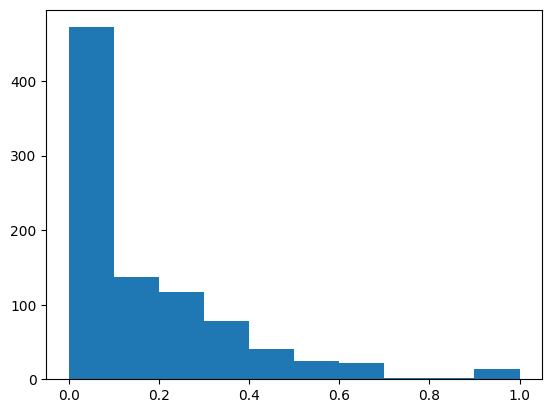

,full_name,statistic_success_action_probs
491,Sven Braken,1.0
592,Domagoj Vida,1.0
201,Diego Falcinelli,1.0
348,Bafodé Diakité,1.0
608,İrfan Can Kahveci,1.0
...,...,...
234,Elseid Hysaj,0.0
224,Nikola Maksimović,0.0
223,Alessandro Diamanti,0.0
222,Marko Grujić,0.0


In [16]:
# from sklearn.cluster import DBSCAN
# from sklearn.neighbors import NearestNeighbors
# from sklearn.neighbors import LocalOutlierFactor
# from sklearn.ensemble import IsolationForest
# import smogn

# # Inspect Xgoal Probabilites Player sorted from the highest
# directory_model = MAPS_PLAYER_SKILL_PROBABILITIES_GENERATOR["xgoal"]["model_directory"]
# output_csv_filename = MAPS_PLAYER_SKILL_PROBABILITIES_GENERATOR["xgoal"]["csv_output_filename"]
# xgoal_player_probs_df = pd.read_csv(directory_model + output_csv_filename)
# xgoal_player_probs_df.sort_values(by="statistic_success_action_probs", ascending=False, inplace=True)

# player_skills_column_included = ["acceleration", "aggression", "agility", "balance", "ball_control",
#                                  "composure", "crossing", "curve", "dribbling", "finishing",
#                                  "freekick_accuracy", "heading_accuracy", "interceptions", "jumping", "long_passing",
#                                  "long_shots", "marking", "penalties", "positioning", "reactions",
#                                  "shot_power", "sliding_tackle", "sprint_speed", "stamina", "short_passing",
#                                  "standing_tackle", "strength", "vision", "volleys"]
# xgoal_player_probs_df[player_skills_column_included] = xgoal_player_probs_df[player_skills_column_included] / 100

# # min_samples = 62
# # neighbors = NearestNeighbors(n_neighbors=min_samples)
# # neighbors_fit = neighbors.fit(xgoal_player_probs_df[player_skills_column_included + ["statistic_success_action_among_players", "statistic_success_action_probs"]])
# # distances, indices = neighbors_fit.kneighbors(xgoal_player_probs_df[player_skills_column_included + ["statistic_success_action_among_players", "statistic_success_action_probs"]])
# # distances = np.sort(distances, axis=0)
# # distances = distances[:,1]
# # plt.axis([900, 1100, 0.4, 0.7])
# # plt.plot(distances)

# epsilon = 0.575
# min_samples = 62
# dbscan = DBSCAN(eps=epsilon, min_samples=min_samples)
# dbscan.fit(xgoal_player_probs_df[player_skills_column_included + ["statistic_success_action_among_players", "statistic_success_action_probs"]])
# labels = dbscan.labels_
# outliers_data = xgoal_player_probs_df[labels == -1]
# # outliers_data[["full_name", "statistic_success_action_probs"]]
# # plt.scatter(xgoal_player_probs_df["statistic_success_action_probs"], xgoal_player_probs_df["statistic_success_action_among_players"], c=labels)

# xgoal_player_probs_df = xgoal_player_probs_df[~xgoal_player_probs_df.index.isin(outliers_data.index)]
# scaler = preprocessing.MinMaxScaler(feature_range=(0,1))
# xgoal_player_probs_df[["statistic_success_action_probs"]] = scaler.fit_transform(xgoal_player_probs_df[["statistic_success_action_probs"]])
# plt.hist(xgoal_player_probs_df["statistic_success_action_probs"])
# plt.show()
# xgoal_player_probs_df[["full_name", "statistic_success_action_probs"]].sort_values(by="statistic_success_action_probs", ascending=False)

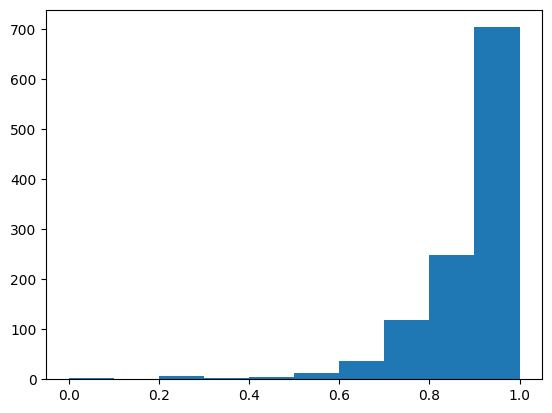

,full_name,statistic_success_action_probs,statistic_success_action_among_players,statistic_success_total
1364,Yassine Bounou,1.000000,0.000266,0.000266
713,Thomas Monconduit,1.000000,0.000089,0.000089
847,이강인 Kangin Lee,1.000000,0.000087,0.000087
536,Jonathan Tah,1.000000,0.000087,0.000087
1008,Jeremain Lens,1.000000,0.000086,0.000086
...,...,...,...,...
1112,Manuel Jesús Vázquez Florido,0.230769,0.000014,0.000012
108,Tobias Sana,0.210526,0.000021,0.000017
1003,Mathias Jensen,0.166667,0.000019,0.000016
1266,Alfa Semedo Esteves,0.000000,0.000005,0.000004


In [17]:
from sklearn.cluster import DBSCAN
from sklearn.neighbors import NearestNeighbors

# Inspect Xdribble Probabilites Player sorted from the highest
directory_model = MAPS_PLAYER_SKILL_PROBABILITIES_GENERATOR["xdribble"]["model_directory"]
output_csv_filename = MAPS_PLAYER_SKILL_PROBABILITIES_GENERATOR["xdribble"]["csv_output_filename"]
xdribble_player_probs_df = pd.read_csv(directory_model + output_csv_filename)
xdribble_player_probs_df.sort_values(by="statistic_success_action_among_players", ascending=False, inplace=True)

player_skills_column_included = ["acceleration", "aggression", "agility", "balance", "ball_control",
                                 "composure", "crossing", "curve", "dribbling", "finishing",
                                 "freekick_accuracy", "heading_accuracy", "interceptions", "jumping", "long_passing",
                                 "long_shots", "marking", "penalties", "positioning", "reactions",
                                 "shot_power", "sliding_tackle", "sprint_speed", "stamina", "short_passing",
                                 "standing_tackle", "strength", "vision", "volleys"]
xdribble_player_probs_df[player_skills_column_included] = xdribble_player_probs_df[player_skills_column_included] / 100

# min_samples = 62
# neighbors = NearestNeighbors(n_neighbors=min_samples)
# neighbors_fit = neighbors.fit(xdribble_player_probs_df[player_skills_column_included + ["statistic_success_action_among_players", "statistic_success_action_probs"]])
# distances, indices = neighbors_fit.kneighbors(xdribble_player_probs_df[player_skills_column_included + ["statistic_success_action_among_players", "statistic_success_action_probs"]])
# distances = np.sort(distances, axis=0)
# distances = distances[:,1]
# plt.axis([1200, 1400, 0.4, 0.6])
# plt.plot(distances)

epsilon = 0.5
min_samples = 62
dbscan = DBSCAN(eps=epsilon, min_samples=min_samples)
dbscan.fit(xdribble_player_probs_df[player_skills_column_included + ["statistic_success_action_among_players", "statistic_success_action_probs"]])
labels = dbscan.labels_
outliers_data = xdribble_player_probs_df[labels == -1]
# outliers_data[["full_name", "statistic_success_action_probs"]]
# plt.scatter(xdribble_player_probs_df["statistic_success_action_probs"], xdribble_player_probs_df["statistic_success_action_among_players"])

xdribble_player_probs_df = xdribble_player_probs_df[~xdribble_player_probs_df.index.isin(outliers_data.index)]
scaler = preprocessing.MinMaxScaler(feature_range=(0,1))
xdribble_player_probs_df[["statistic_success_action_probs"]] = scaler.fit_transform(xdribble_player_probs_df[["statistic_success_action_probs"]])
plt.hist(xdribble_player_probs_df["statistic_success_action_probs"])
plt.show()
xdribble_player_probs_df[["full_name", "statistic_success_action_probs", "statistic_success_action_among_players", "statistic_success_total"]].sort_values(by="statistic_success_action_probs", ascending=False)